# M2 - Calibración

Para poder extraer las dimensiones reales (mm) de la longitud, anchura y altura es necesario que el sistema disponga de algún tipo de calibración. Para ello la forma más rápida es disponer de un damero (Checkerboard) de dimensiones exactas y conocidas como el de la figura, en el que cada una de las inserciones internas mide exactamente 10 mm de lado.

```{figure} .././assets/checkerboard_10x10.png
:name: Figura_WP1_imagen.4
:alt: Checkerboard
:width: 75%
:align: center

Checkerdoard (damero) para calibración
```
Si $𝐿_{px}$ es la longitud medida en píxeles de un objeto cuya longitud real $L_{mm}$ es conocida (10 mm en nuestro damero), la escala se define como:

$$
𝑠[mm/px]=\dfrac{L_{mm}}{𝐿_{px}}
$$
  
Para robustez, se usa la mediana de múltiples aristas horizontales y verticales [[Zang, Z., 2020](https://doi.org/10.1109/34.888718)]. La incertidumbre relativa de primer orden es:
```{math}
:label: incertidumbre_calibracion
\left(\frac{\sigma_s}{s}\right)^2 \;\approx\; 
\left(\frac{\sigma_{L_{\text{mm}}}}{L_{\text{mm}}}\right)^2 \;+\; 
\left(\frac{\sigma_{L_{\text{px}}}}{L_{\text{px}}}\right)^2
```

El flujo UML que resuelve la calibración es el siguiente:

```{figure} .././assets/calibracion.png
:name: Figura_WP1_imagen.5
:alt: UML Calibracion
:width: 75%
:align: center

UML proceso de calibración
```

In [1]:
## INSTALACION DE LIBRERIAS
# Ejecutar la siguiente línea si no se ha previmente

#!pip install opencv-python

In [10]:
## IMPORT Y UTILIDAES DE E/S

# Importa librerías y define utilidades para leer/escribir JSON con seguridad.

import json
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Optional, Dict, Any, Tuple

import numpy as np
import cv2

def load_json(path: Path) -> Optional[dict]:
    """Carga un JSON si existe; devuelve None si no existe."""
    if not path.exists():
        return None
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

def save_json(path: Path, data: dict) -> None:
    """Guarda un dict como JSON (UTF-8, con indentado) y crea carpetas si no existen."""
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

In [11]:
## CONFIGURACION 

# fija rutas y parámetros del patrón para el damero

# === CONFIG (ajustada al damero de calibrado) ===================================
CALIB_FILE = Path("./calibracion_px_mm.json")

# Patrón de referencia: DAMERO 10x10 cuadrados => 9x9 intersecciones internas
CHECKERBOARD_SQUARE_MM = 10.0
CHECKERBOARD_SQUARES_COLS = 10   # número de cuadrados horizontales
CHECKERBOARD_SQUARES_ROWS = 10   # número de cuadrados verticales
CHECKERBOARD_INTERNAL_COLS = CHECKERBOARD_SQUARES_COLS - 1  # 9 intersecciones internas
CHECKERBOARD_INTERNAL_ROWS = CHECKERBOARD_SQUARES_ROWS - 1  # 9 intersecciones internas

# Agregación robusta de distancias entre esquinas: "median" o "mean"
AGGREGATION = "median"

# Usa la imagen del  damero de referencia.
IMG_PATH = Path(".././assets/checkerboard_10mm_200pxmm.png")


In [12]:
## ESTRUCTURA DE CALIBRACION Y PERSISTENCIA

# Define la estructura (dataclass) que se guardará en JSON y las funciones de lectura/escritura
# del fichero de calibración

@dataclass
class Calibration:
    """
    Estructura persistente de calibración.
    - mm_per_px: escala (milímetros por píxel).
    - method: método usado ("checkerboard").
    - meta: metadatos/diagnósticos (estadísticos de distancias en píxeles, etc.).
    """
    mm_per_px: float
    method: str
    meta: Dict[str, Any]

def load_calibration(path: Path) -> Optional[Calibration]:
    """Lee la calibración desde JSON; devuelve None si no existe o si hay formato inválido."""
    data = load_json(path)
    if data is None:
        return None
    try:
        return Calibration(
            mm_per_px=float(data["mm_per_px"]),
            method=str(data["method"]),
            meta=dict(data["meta"]),
        )
    except Exception:
        return None

def save_calibration(path: Path, cal: Calibration) -> None:
    """Persistencia de calibración a JSON."""
    save_json(path, asdict(cal))

In [13]:
## DETECCIÓN DEL DAMERO Y CÁLCULO mm/px

def detect_checkerboard_scale(
    img_bgr: np.ndarray,
    cols_internal: int,
    rows_internal: int,
    square_mm: float,
    aggregation: str = "median"
) -> Optional[Tuple[float, Dict[str, Any]]]:
    """
    Detecta un damero de (cols_internal x rows_internal) intersecciones internas.
    Calcula mm/px usando la mediana (por defecto) de distancias entre esquinas adyacentes.

    Devuelve: (mm_per_px, diagnostics) si detecta; None si no detecta.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
    found, corners = cv2.findChessboardCorners(gray, (cols_internal, rows_internal), flags)

    if not found or corners is None:
        return None

    # Refinamiento subpíxel
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1e-4)
    corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    corners = corners.reshape(-1, 2)  # N x 2

    # Distancias horizontales
    horiz = []
    for r in range(rows_internal):
        for c in range(cols_internal - 1):
            i = r * cols_internal + c
            j = r * cols_internal + (c + 1)
            d = np.linalg.norm(corners[i] - corners[j])
            if d > 0:
                horiz.append(d)

    # Distancias verticales
    vert = []
    for r in range(rows_internal - 1):
        for c in range(cols_internal):
            i = r * cols_internal + c
            j = (r + 1) * cols_internal + c
            d = np.linalg.norm(corners[i] - corners[j])
            if d > 0:
                vert.append(d)

    dists = np.array(horiz + vert, dtype=float)
    if dists.size == 0:
        return None

    # px por cuadrado (mediana por robustez ante outliers)
    px_per_square = np.median(dists) if aggregation == "median" else np.mean(dists)
    mm_per_px     = square_mm / px_per_square

    diagnostics = {
        "pattern": "checkerboard",
        "internal_cols": int(cols_internal),
        "internal_rows": int(rows_internal),
        "square_mm": float(square_mm),
        "edges_count": int(dists.size),
        "px_per_square_summary": {
            "mean": float(np.mean(dists)),
            "median": float(np.median(dists)),
            "std": float(np.std(dists, ddof=1)) if dists.size > 1 else 0.0
        },
        "aggregation": aggregation
    }
    return mm_per_px, diagnostics


In [14]:
## FUNCIÓN DE CALIBRACIÓN

# implementa literalmente el diagrama de decisiones: 
# - usar calibración vigente (permanente) salvo que el usuario fuerce recalibración;
# - si no hay calibración o se fuerza, intenta detectar y calcular; 
# - si falla, `sin_escala`

def run_calibration_pipeline_checkerboard(
    calib_file: Path,
    img_path: Path,
    cols_internal: int,
    rows_internal: int,
    square_mm: float,
    aggregation: str = "median",
    force_recalibrate: bool = False
) -> Dict[str, Any]:
    """
    UML “M2 - Calibración de escala”:

    if (¿Calibración vigente?) then (Sí)
        :Usar escala px→mm guardada;
    else (No)
        :Detectar patrón referencia;
        if (¿Detectado?) then (Sí)
            :Calcular escala px→mm; (y guardar)
        else (No)
            :Marcar sin_escala;

    'Vigente' = existe calibración en disco y NO se fuerza recalibración.
    """
    # 1) ¿Calibración 'vigente'?
    if not force_recalibrate:
        cal = load_calibration(calib_file)
        if cal is not None and cal.method == "checkerboard":
            return {
                "estado": "vigente",
                "mm_per_px": cal.mm_per_px,
                "method": cal.method,
                "meta": cal.meta
            }

    # 2) No vigente (o se fuerza) -> Detectar patrón referencia
    if not img_path.exists():
        return {"estado": "sin_escala", "motivo": f"Imagen no encontrada: {str(img_path)}"}

    img = cv2.imread(str(img_path))
    if img is None:
        return {"estado": "sin_escala", "motivo": f"No se pudo abrir la imagen: {str(img_path)}"}

    res = detect_checkerboard_scale(
        img_bgr=img,
        cols_internal=cols_internal,
        rows_internal=rows_internal,
        square_mm=square_mm,
        aggregation=aggregation
    )

    # 3) ¿Detectado?
    if res is None:
        return {"estado": "sin_escala", "motivo": "No se detectó el damero en la imagen"}

    # 4) Calcular escala y guardar
    mm_per_px, diag = res
    cal = Calibration(
        mm_per_px=float(mm_per_px),
        method="checkerboard",
        meta={"diagnostics": diag}
    )
    save_calibration(calib_file, cal)

    return {
        "estado": "recalibrado",
        "mm_per_px": cal.mm_per_px,
        "method": cal.method,
        "meta": cal.meta
    }

Para calibrar el sistema basta con ejecutar una llamada a la función anterior `run_calibration_pipeline_checkerboard()` del siguiente modo:

In [15]:
calibration = run_calibration_pipeline_checkerboard(
    calib_file=CALIB_FILE,
    img_path=IMG_PATH,
    cols_internal=CHECKERBOARD_INTERNAL_COLS,
    rows_internal=CHECKERBOARD_INTERNAL_ROWS,
    square_mm=CHECKERBOARD_SQUARE_MM,          
    aggregation=AGGREGATION,                   
    force_recalibrate=False
)
print("Resultado de la calibración: \n")
calibration

Resultado de la calibración: 



{'estado': 'vigente',
 'mm_per_px': 0.05,
 'method': 'checkerboard',
 'meta': {'diagnostics': {'pattern': 'checkerboard',
   'internal_cols': 9,
   'internal_rows': 9,
   'square_mm': 10.0,
   'edges_count': 144,
   'px_per_square_summary': {'mean': 200.0, 'median': 200.0, 'std': 0.0},
   'aggregation': 'median'}}}

Este módulo también proporciona algunas **utilidades de conversión** que permiten, a partir de un calibrado: obtener la escala (`get_mm_per_px`), traducir pixeles a mm (`px_to_mm`) o transformar mm a pixeles (`mm_to_px`).

In [16]:
## UTILIDADES DE CONVERSION

# Funciones auxiliares para convertir medidas en el pipeline de visión.

def get_mm_per_px(calib_file: Path = CALIB_FILE) -> float:
    """Devuelve la escala mm/px leída del archivo de calibración."""
    cal = load_calibration(calib_file)
    if cal is None:
        raise RuntimeError(f"No hay calibración guardada en {calib_file}. Ejecuta el pipeline primero.")
    return float(cal.mm_per_px)

def px_to_mm(value_px: float, mm_per_px: float) -> float:
    """Convierte longitudes en píxeles a milímetros."""
    return float(value_px) * float(mm_per_px)

def mm_to_px(value_mm: float, mm_per_px: float) -> float:
    """Convierte longitudes en milímetros a píxeles."""
    if mm_per_px <= 0:
        raise ValueError("mm_per_px debe ser positivo.")
    return float(value_mm) / float(mm_per_px)

Un ejemplo de uso de estas funciones sería:

In [17]:
print(f"Escala actual mm/px: {get_mm_per_px()}")
print(f"Longitud en milímetros de 1250 px: {px_to_mm(1250, get_mm_per_px())} mm")
print(f"Longitud en piexels de 100 mm: {mm_to_px(100, get_mm_per_px())} pixeles")

Escala actual mm/px: 0.05
Longitud en milímetros de 1250 px: 62.5 mm
Longitud en piexels de 100 mm: 2000.0 pixeles


Para garantizar y auditar que el proceso de calibración se realiza adecuadamente se han definido algunas funciones auxiliares:

**Control visual y verificación del damero**

In [18]:
## OVERLAY DE CONTROL VISUAL Y .png DIAGNÓSTICO

# Su función es verificar y documentar que la detección ha sido correcta.

from datetime import datetime

def overlay_checkerboard_and_save(
    img_path: Path,
    out_path: Path,
    cols_internal: int,
    rows_internal: int,
    mm_per_px: float = None,
    draw_rect: bool = True
) -> dict:
    """
    Dibuja esquinas del damero y anota mm/px (si disponible). Guarda PNG.
    Devuelve dict con 'ok' y detalles/motivo de fallo.
    """
    if not img_path.exists():
        return {"ok": False, "motivo": f"Imagen no encontrada: {str(img_path)}"}

    img = cv2.imread(str(img_path))
    if img is None:
        return {"ok": False, "motivo": f"No se pudo abrir la imagen: {str(img_path)}"}

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
    found, corners = cv2.findChessboardCorners(gray, (cols_internal, rows_internal), flags)

    vis = img.copy()
    if not found or corners is None:
        cv2.putText(vis, "Checkerboard NO detectado", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2, cv2.LINE_AA)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        ok = cv2.imwrite(str(out_path), vis)
        return {"ok": bool(ok), "motivo": "No se detecto el damero; PNG guardado con aviso.", "out": str(out_path)}

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1e-4)
    corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    cv2.drawChessboardCorners(vis, (cols_internal, rows_internal), corners, found)

    if draw_rect:
        pts = corners.reshape(-1, 2)
        x_min, y_min = np.floor(pts.min(axis=0)).astype(int)
        x_max, y_max = np.ceil(pts.max(axis=0)).astype(int)
        cv2.rectangle(vis, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    y0 = 30
    cv2.putText(vis, f"Damero {cols_internal}x{rows_internal} (intersecciones)", (20, y0),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50, 220, 50), 2, cv2.LINE_AA)
    y0 += 30
    if mm_per_px is not None:
        cv2.putText(vis, f"Escala: {mm_per_px:.6f} mm/px", (20, y0),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50, 220, 50), 2, cv2.LINE_AA)
        y0 += 30
    cv2.putText(vis, f"Timestamp: {datetime.now().isoformat(timespec='seconds')}", (20, y0),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 200, 200), 2, cv2.LINE_AA)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    ok = cv2.imwrite(str(out_path), vis)
    return {"ok": bool(ok), "motivo": "" if ok else "cv2.imwrite fallo", "out": str(out_path)}


El siguiente código muestra cómo ejecutar la función `overlay_checkerboard_and_save`.

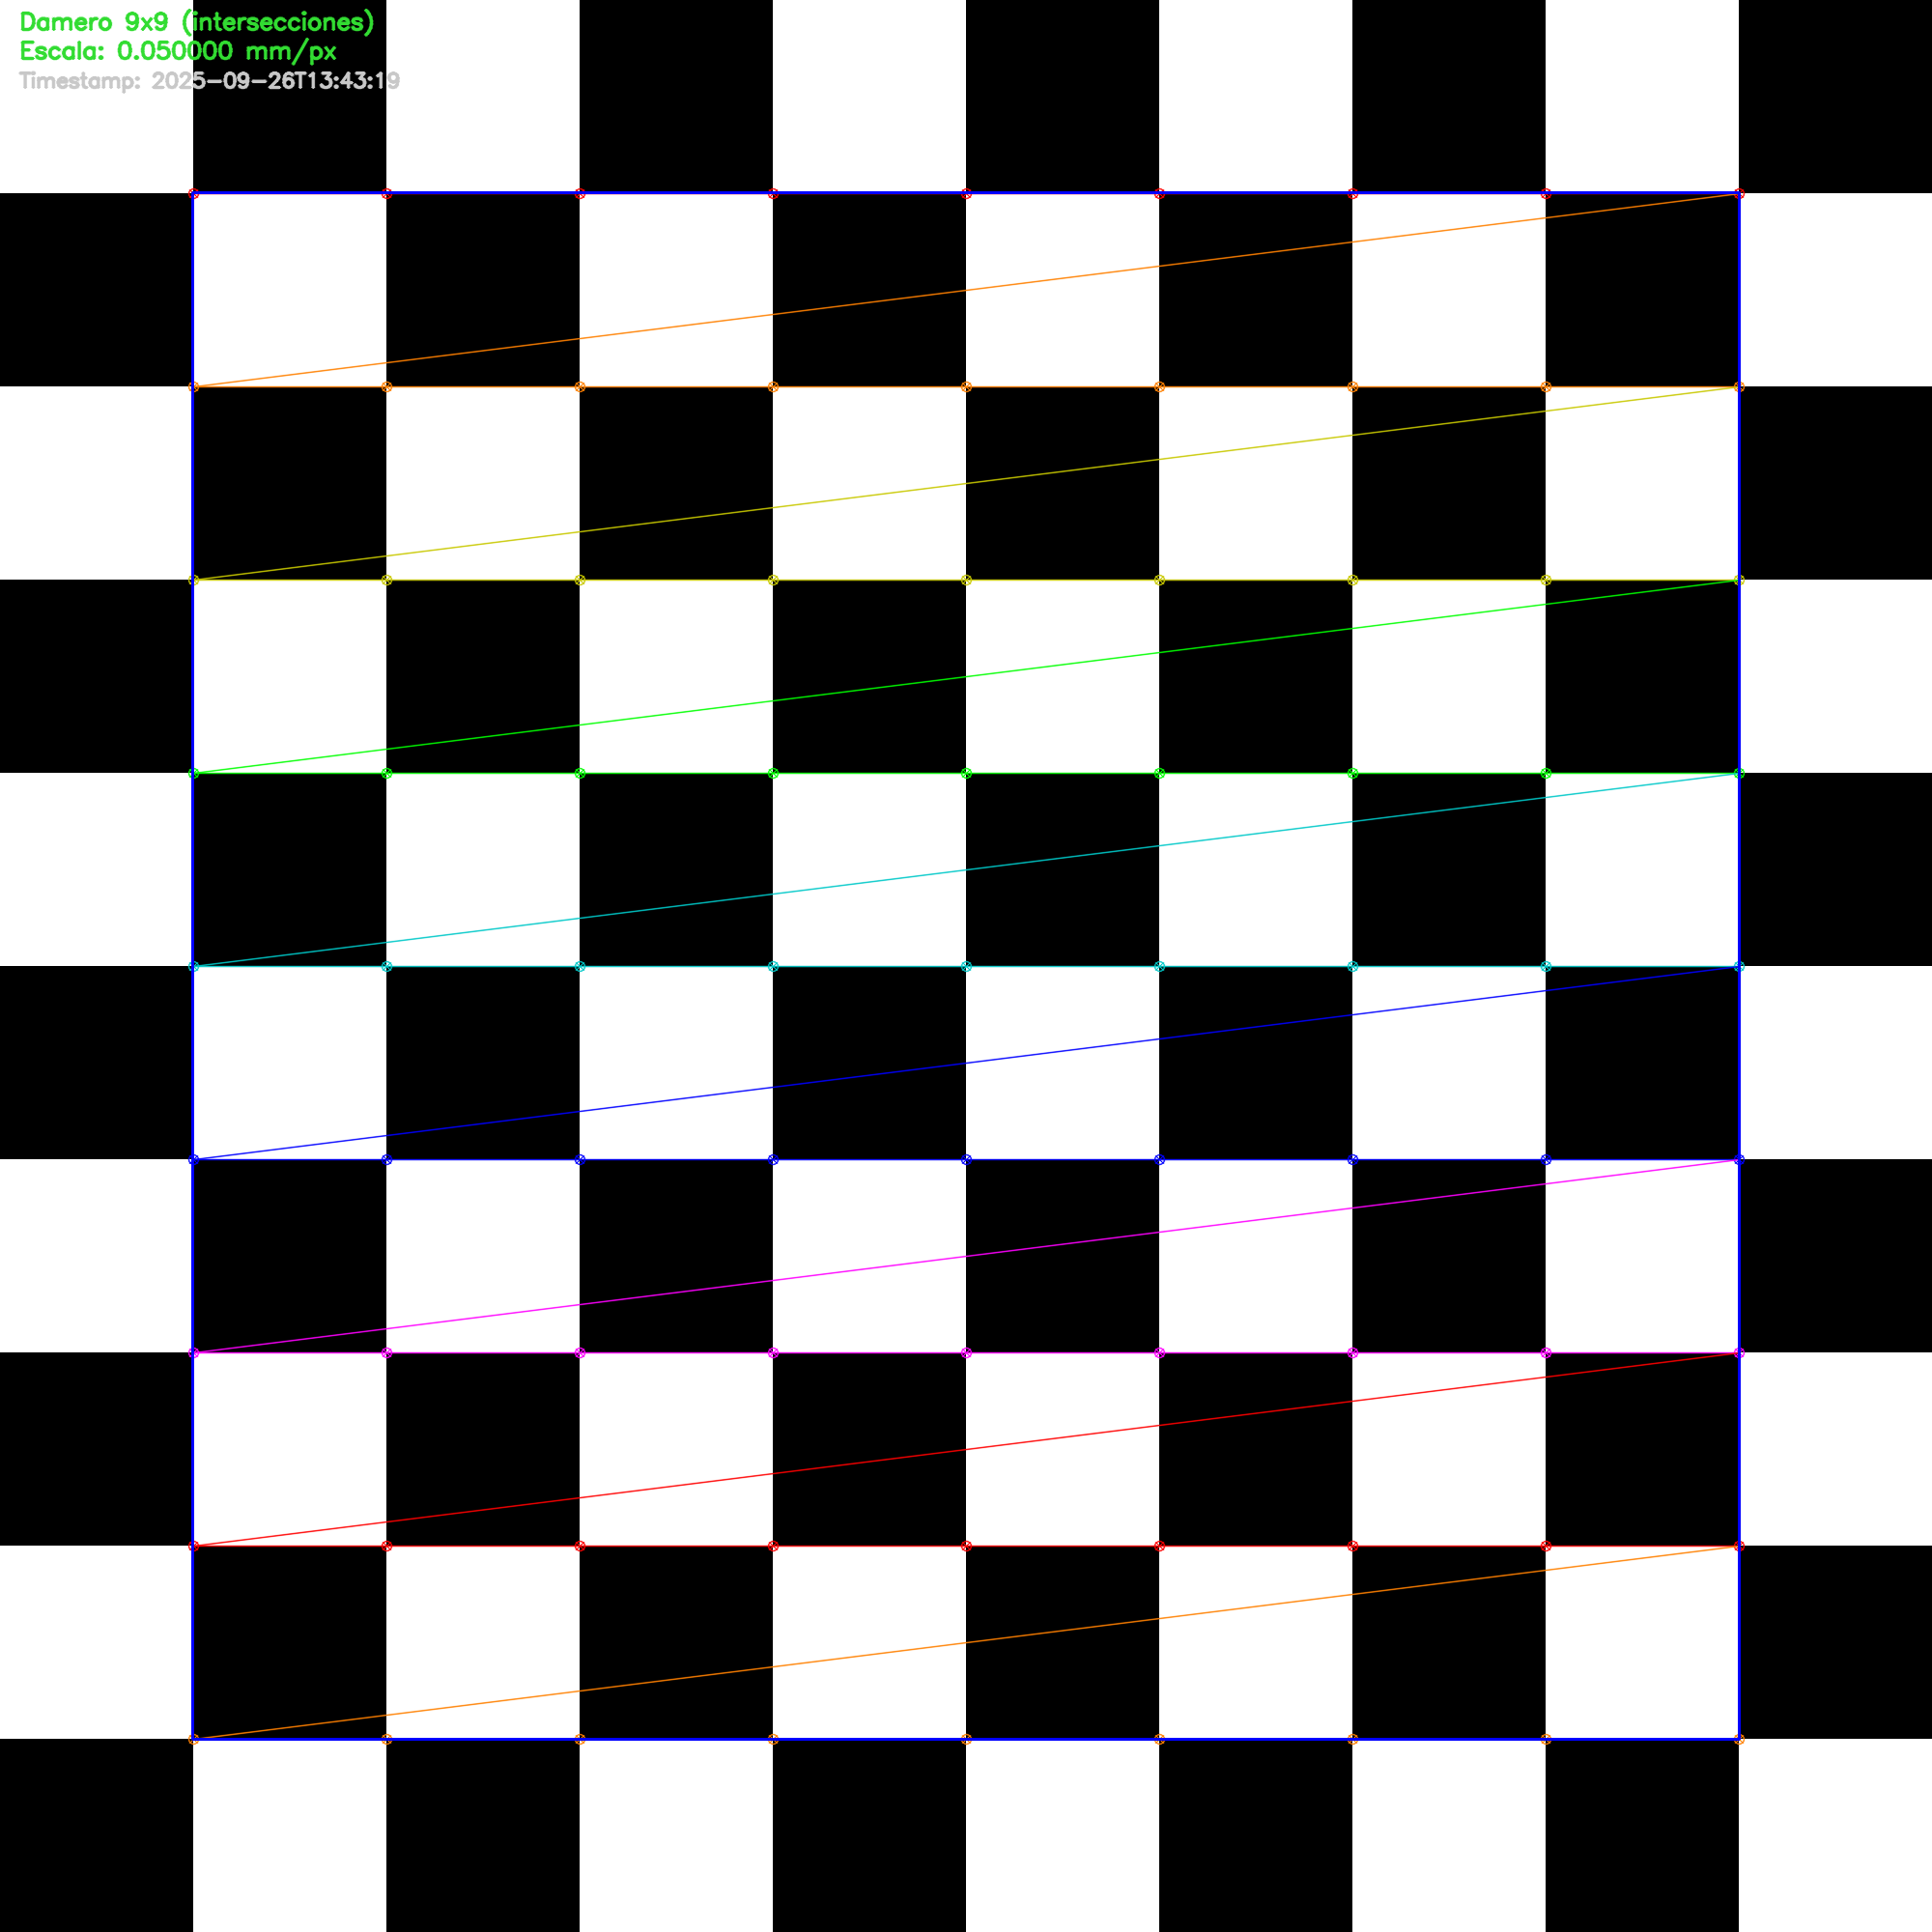

{'ok': True, 'motivo': '', 'out': 'diagnosticos\\diagnostico_calibracion.png'}

In [19]:
from pathlib import Path
from IPython.display import Image, display

# Lee la escala guardada (mm/px) para anotarla en la imagen
mm_per_px_annot = get_mm_per_px()

OUT_PNG = Path("./diagnosticos/diagnostico_calibracion.png")

overlay_info = overlay_checkerboard_and_save(
    img_path=IMG_PATH,
    out_path=OUT_PNG,
    cols_internal=CHECKERBOARD_INTERNAL_COLS,  # 9
    rows_internal=CHECKERBOARD_INTERNAL_ROWS,  # 9
    mm_per_px=mm_per_px_annot,                 # se anotará "Escala: X mm/px"
    draw_rect=True
)

# Mostrar la imagen resultante en el notebook
DISPLAY_WIDTH = 800  # px
display(Image(filename=str(OUT_PNG), embed=True, width=DISPLAY_WIDTH))

# (Opcional) Ver detalles del overlay/guardado
overlay_info

**Validación numérica**

Esta función lee la calibración existente y estima la incertidumbre según la ecuación {eq}`incertidumbre_calibracion`

In [20]:
## VALIDACIÓN NUMÉRICA

# Lee la calibración y reporta mm/px y px/mm estimado la incertidumbre

def load_calibration_dict(path: Path) -> dict:
    if not path.exists():
        raise FileNotFoundError(f"No existe el archivo de calibración: {path}")
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

def validation_report(calib_json: dict, assume_square_exact_mm=True, square_sigma_mm=0.0):
    """
    Reporta mm/px, px/mm e incertidumbre estimada.
    - Si conoces la tolerancia del patrón (p.ej. ±0.02 mm), usa assume_square_exact_mm=False y square_sigma_mm=0.02.
    """
    mm_per_px = float(calib_json["mm_per_px"])
    px_per_mm = 1.0 / mm_per_px if mm_per_px > 0 else np.nan

    diag = calib_json.get("meta", {}).get("diagnostics", {})
    pattern = diag.get("pattern", "checkerboard")
    px_sum = diag.get("px_per_square_summary", {})
    aggregation = diag.get("aggregation", "median")
    square_mm = float(diag.get("square_mm", np.nan))

    center_px = px_sum.get("median" if aggregation == "median" else "mean", None)
    std_px = px_sum.get("std", None)
    n_edges = diag.get("edges_count", None)

    sigma_s = None
    ci95 = (None, None)
    details = {}

    if center_px and std_px is not None and center_px > 0:
        sigma_square = 0.0 if assume_square_exact_mm else float(square_sigma_mm)

        # Error estándar del estimador: media vs mediana
        if n_edges and n_edges > 1:
            if aggregation == "mean":
                se_px = std_px / np.sqrt(n_edges)
            else:
                se_px = 1.253 * std_px / np.sqrt(n_edges)  # aprox. SE de la mediana
        else:
            se_px = std_px

        # Propagación de errores (1er orden)
        rel_sq = (sigma_square / square_mm)**2 if (square_mm and square_mm > 0) else 0.0
        rel_px = (se_px / center_px)**2
        rel_s  = np.sqrt(rel_sq + rel_px)

        sigma_s = rel_s * mm_per_px
        ci95 = (mm_per_px - 1.96 * sigma_s, mm_per_px + 1.96 * sigma_s)

        details = {
            "center_px": center_px,
            "std_px_edges": std_px,
            "se_px_used": se_px,
            "n_edges": n_edges,
            "aggregation": aggregation,
            "square_mm": square_mm,
            "sigma_square_mm": sigma_square,
            "rel_uncertainty_s": rel_s
        }

    return {
        "mm_per_px": mm_per_px,
        "px_per_mm": px_per_mm,
        "method": calib_json.get("method", ""),
        "pattern": pattern,
        "uncertainty_sigma_mm_per_px": sigma_s,
        "ci95_mm_per_px": ci95,
        "diagnostics_available": (std_px is not None),
        "details": details
    }

In [21]:
# === Ejecutar validación ===
print("Validación numérica e incertidumbre:")
cal_data = load_calibration_dict(CALIB_FILE)
report = validation_report(cal_data, assume_square_exact_mm=True, square_sigma_mm=0.0)
report

Validación numérica e incertidumbre:


{'mm_per_px': 0.05,
 'px_per_mm': 20.0,
 'method': 'checkerboard',
 'pattern': 'checkerboard',
 'uncertainty_sigma_mm_per_px': np.float64(0.0),
 'ci95_mm_per_px': (np.float64(0.05), np.float64(0.05)),
 'diagnostics_available': True,
 'details': {'center_px': 200.0,
  'std_px_edges': 0.0,
  'se_px_used': np.float64(0.0),
  'n_edges': 144,
  'aggregation': 'median',
  'square_mm': 10.0,
  'sigma_square_mm': 0.0,
  'rel_uncertainty_s': np.float64(0.0)}}

**(Re)calibración forzada**
El usuario puede querer forzar una nueva calibración. La función `recalibrar_y_generar_png()` fuerza recálculo con el damero y genera un PNG de control visual.

In [22]:
## UTILIDAD DE RECALIBRACION FORZADA CON .png DE DIAGNOSTICO

def recalibrar_y_generar_png(
    calib_file: Path,
    img_path: Path,
    cols_internal: int,
    rows_internal: int,
    square_mm: float,
    aggregation: str = "median",
    out_png: Path = Path("./diagnosticos/diagnostico_calibracion.png"),
    timestamp_bgr: tuple = (0, 0, 255),   # ROJO en BGR (por defecto)
    box_bgr: tuple = (255, 0, 0),         # Azul para rectángulo envolvente
    text_bgr: tuple = (50, 220, 50)       # Verde para textos informativos
) -> dict:
    """
    Fuerza la recalibración usando el damero de 'img_path' y genera un PNG de diagnóstico.
    - Dibuja esquinas detectadas, rectángulo envolvente y anota mm/px.
    - Pinta el timestamp en ROJO (BGR=(0,0,255) por defecto).
    
    Parámetros
    ----------
    calib_file : Path
        Ruta del JSON donde se guardará la calibración (mm/px, meta).
    img_path : Path
        Ruta de la imagen del damero (10x10 → 9x9 intersecciones internas).
    cols_internal, rows_internal : int
        Intersecciones internas del damero (p.ej., 9x9 para 10x10 cuadrados).
    square_mm : float
        Tamaño físico del lado de cada cuadrado (mm), p.ej. 10.0.
    aggregation : {"median","mean"}
        Agregación para estimar px por cuadrado (robusta por defecto: "median").
    out_png : Path
        Ruta de salida del PNG de diagnóstico.
    timestamp_bgr : tuple
        Color BGR para el timestamp (rojo por defecto).
    box_bgr : tuple
        Color BGR del rectángulo envolvente (azul por defecto).
    text_bgr : tuple
        Color BGR para textos informativos (verde por defecto).
    
    Returns
    -------
    dict con claves:
      - "recal": dict con el resultado de la recalibración (estado, mm_per_px, meta)
      - "overlay": dict con {"ok": bool, "out": str(ruta_png)} (o motivo de fallo)
      - "mm_per_px": float o None (si no disponible)
      - "estado": str (e.g., "recalibrado", "vigente", "sin_escala")
    """
    from datetime import datetime

    # 1) Forzar recalibración (usa la función del pipeline del notebook)
    recal = run_calibration_pipeline_checkerboard(
        calib_file=calib_file,
        img_path=img_path,
        cols_internal=cols_internal,
        rows_internal=rows_internal,
        square_mm=square_mm,
        aggregation=aggregation,
        force_recalibrate=True
    )

    # 2) Preparar overlay (detectar de nuevo para dibujar) con TIMESTAMP ROJO
    if not img_path.exists():
        return {
            "recal": recal,
            "overlay": {"ok": False, "motivo": f"Imagen no encontrada: {str(img_path)}"},
            "mm_per_px": float(recal["mm_per_px"]) if isinstance(recal, dict) and "mm_per_px" in recal else None,
            "estado": recal.get("estado") if isinstance(recal, dict) else None
        }

    img = cv2.imread(str(img_path))
    if img is None:
        return {
            "recal": recal,
            "overlay": {"ok": False, "motivo": f"No se pudo abrir la imagen: {str(img_path)}"},
            "mm_per_px": float(recal["mm_per_px"]) if isinstance(recal, dict) and "mm_per_px" in recal else None,
            "estado": recal.get("estado") if isinstance(recal, dict) else None
        }

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
    found, corners = cv2.findChessboardCorners(gray, (cols_internal, rows_internal), flags)

    vis = img.copy()
    if not found or corners is None:
        cv2.putText(
            vis, "Checkerboard NO detectado", (20, 40),
            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2, cv2.LINE_AA
        )
        # timestamp en rojo aunque no haya detección
        cv2.putText(
            vis, f"Timestamp: {datetime.now().isoformat(timespec='seconds')}", (20, 80),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, timestamp_bgr, 2, cv2.LINE_AA
        )
    else:
        # Refinar esquinas y dibujarlas
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1e-4)
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        cv2.drawChessboardCorners(vis, (cols_internal, rows_internal), corners, found)

        # Rectángulo envolvente
        pts = corners.reshape(-1, 2)
        x_min, y_min = np.floor(pts.min(axis=0)).astype(int)
        x_max, y_max = np.ceil(pts.max(axis=0)).astype(int)
        cv2.rectangle(vis, (x_min, y_min), (x_max, y_max), box_bgr, 2)

        # Textos informativos (verde por defecto)
        y0 = 30
        cv2.putText(
            vis, f"Damero {cols_internal}x{rows_internal} (intersecciones)", (20, y0),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, text_bgr, 2, cv2.LINE_AA
        )
        y0 += 30
        mmpp = float(recal["mm_per_px"]) if isinstance(recal, dict) and "mm_per_px" in recal else None
        if mmpp is not None:
            cv2.putText(
                vis, f"Escala: {mmpp:.6f} mm/px", (20, y0),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, text_bgr, 2, cv2.LINE_AA
            )
            y0 += 30

        # TIMESTAMP en ROJO
        cv2.putText(
            vis, f"Timestamp: {datetime.now().isoformat(timespec='seconds')}", (20, y0),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, timestamp_bgr, 2, cv2.LINE_AA
        )

    # 3) Guardar PNG
    out_png.parent.mkdir(parents=True, exist_ok=True)
    ok = cv2.imwrite(str(out_png), vis)

    return {
        "recal": recal,
        "overlay": {"ok": bool(ok), "out": str(out_png) if ok else None},
        "mm_per_px": float(recal["mm_per_px"]) if isinstance(recal, dict) and "mm_per_px" in recal else None,
        "estado": recal.get("estado") if isinstance(recal, dict) else None
    }


Un ejemplo de uso de esta función de recalibrado forzado sería:

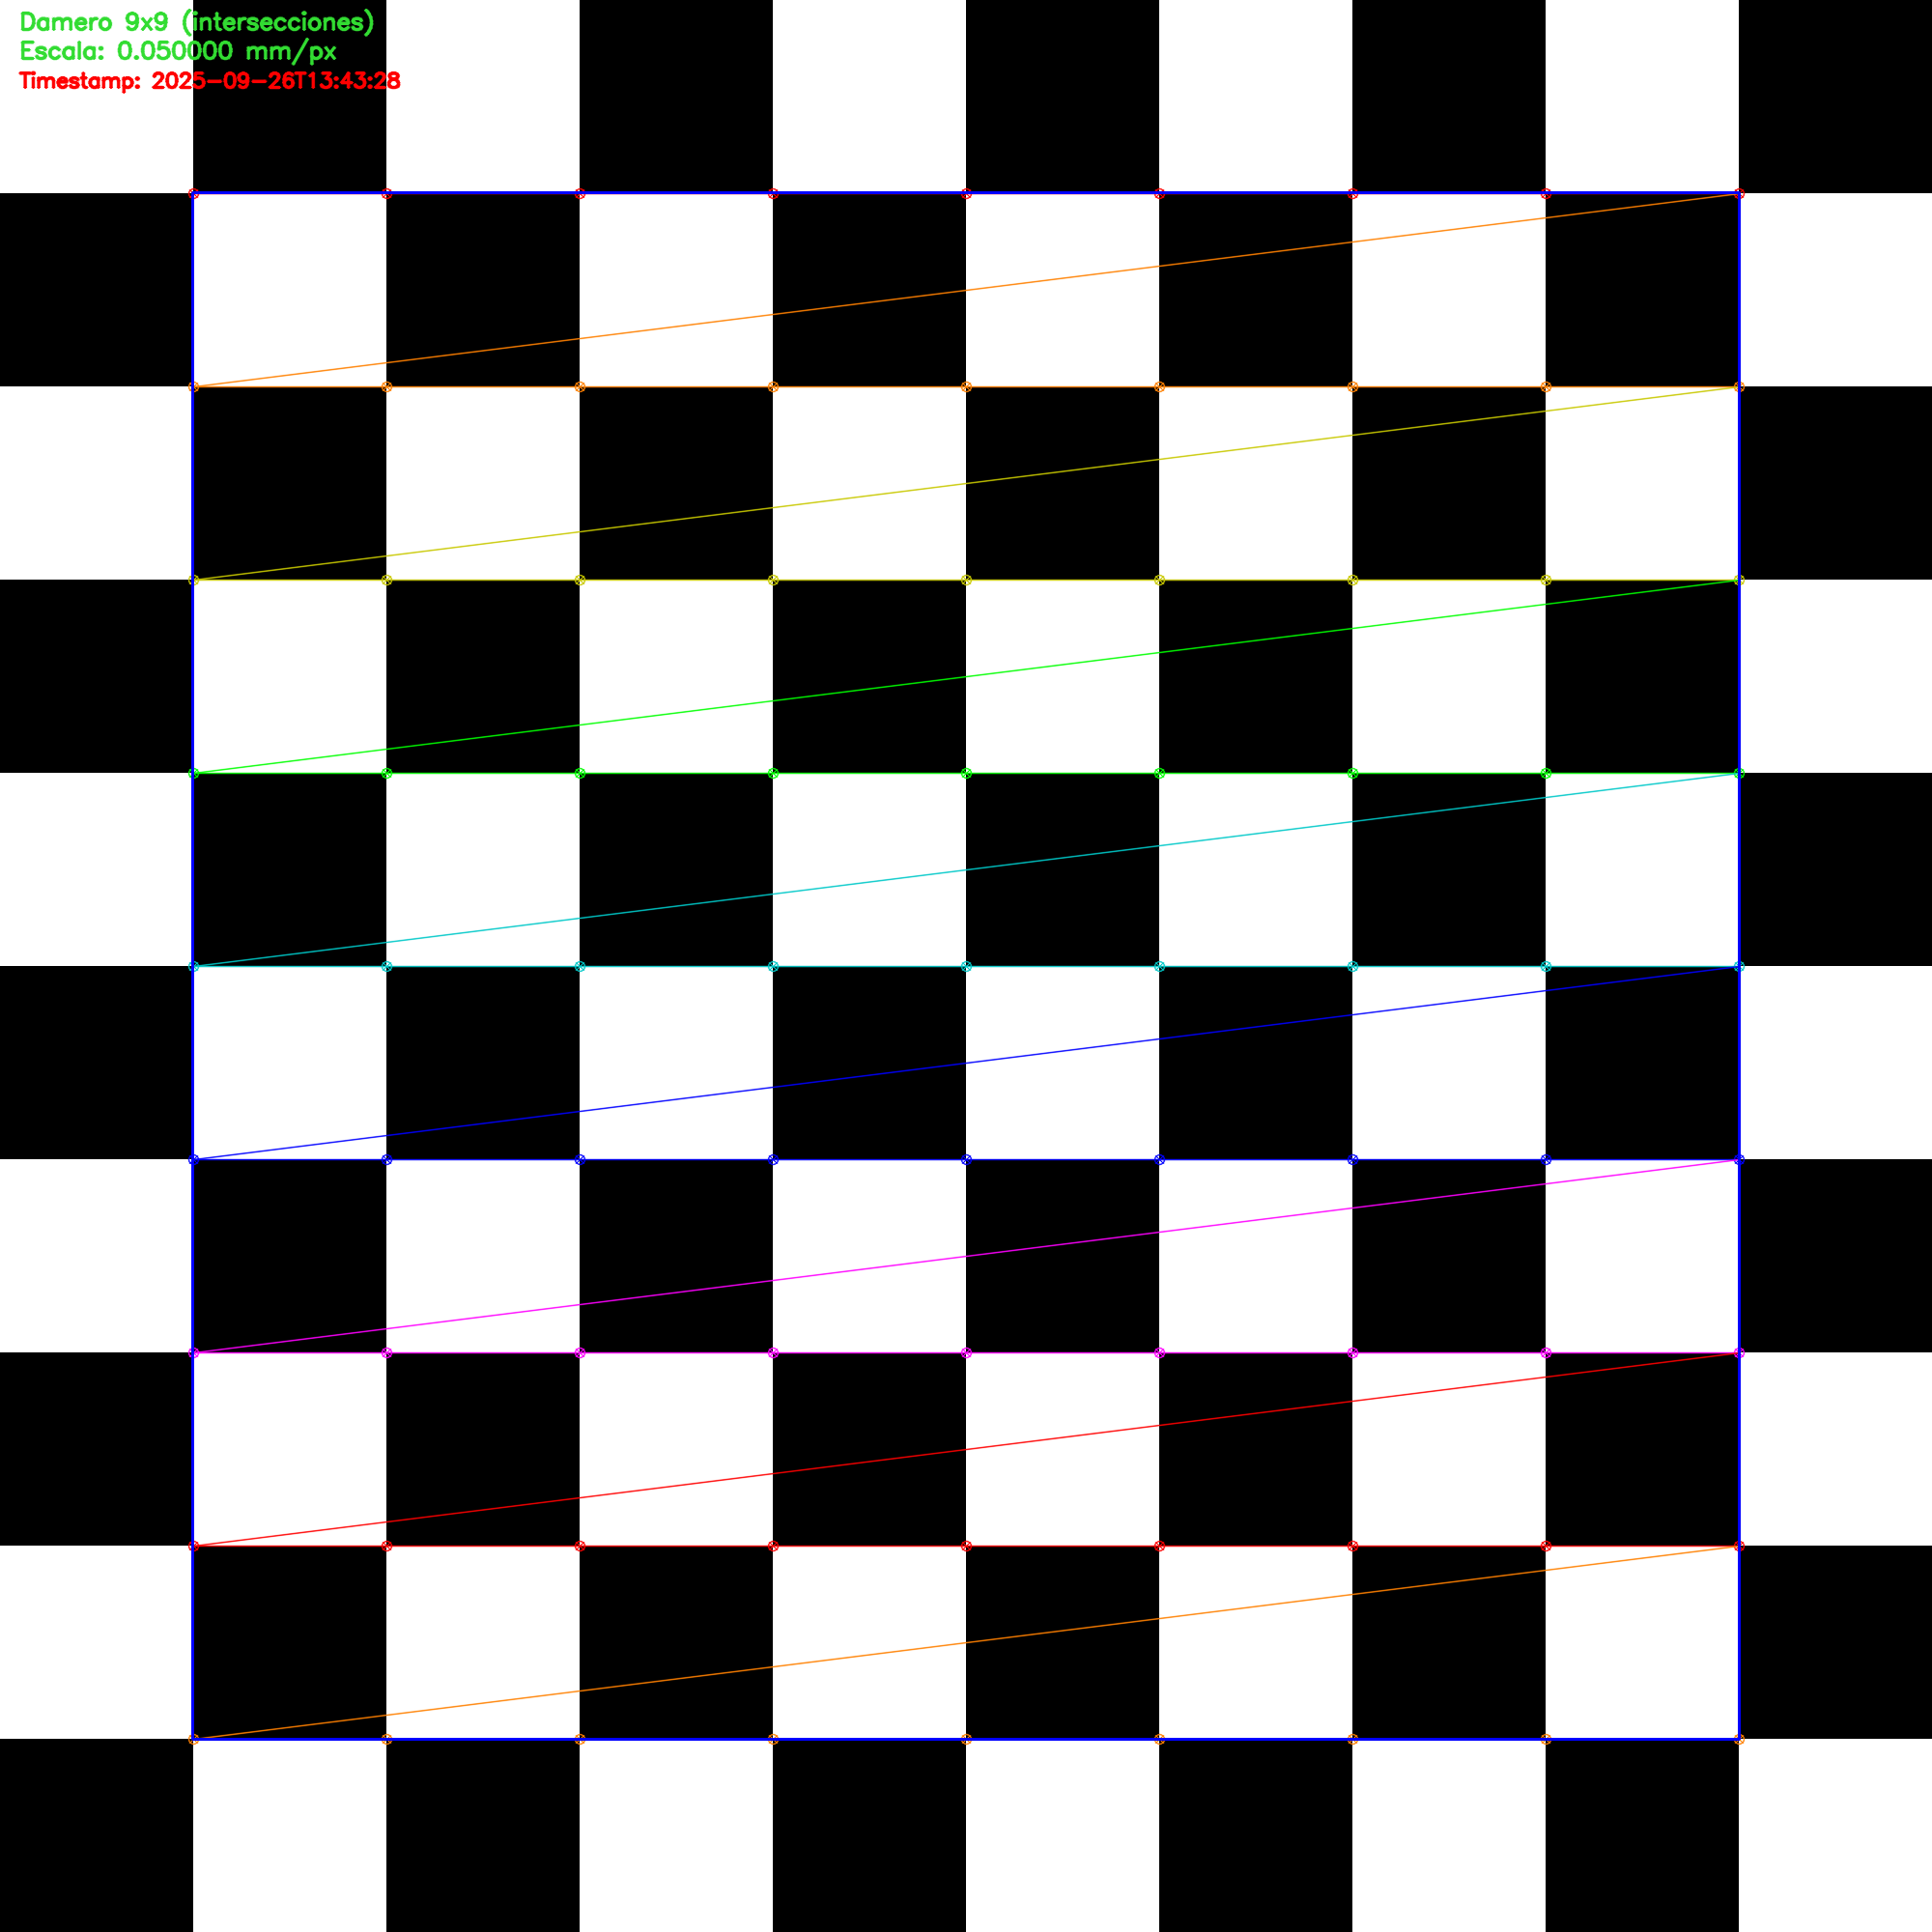

In [23]:
OUT_PNG = Path("./diagnosticos/recalibrado.png")
res = recalibrar_y_generar_png(
    calib_file=CALIB_FILE,
    img_path=IMG_PATH,
    cols_internal=CHECKERBOARD_INTERNAL_COLS,  
    rows_internal=CHECKERBOARD_INTERNAL_ROWS,  
    square_mm=CHECKERBOARD_SQUARE_MM,          
    aggregation=AGGREGATION,                   
    out_png=OUT_PNG
)

res

# Visualización del .png de (re)calibrado
DISPLAY_WIDTH = 800  # px
display(Image(filename=str(OUT_PNG), embed=True, width=DISPLAY_WIDTH))
